Hunter Bennett | Strains Project | June 16 2021

In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff

In [24]:
#### PLOTTING PARAMETERS FOR MANUSCRIPT ####
# # get matplotlib to save readable fonts
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['savefig.dpi'] = 500

# line widths
matplotlib.rcParams['axes.linewidth'] = 1
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1

# adjust defualt color for plots to black
# normal default is a dark gray
COLOR = 'black'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
matplotlib.rcParams['axes.edgecolor'] = COLOR

#### PLOT PARAMETERS FOR THIS PLOT ####

In [25]:
# dataDirectory = '/home/h1bennet/strains/data/ATAC/control_cohort2/'
workingDirectory = '/home/h1bennet/strains_f1/results/00_CB6F1_Control//'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

In [26]:
if not os.path.isdir('./motif_enrichment_heatmaps/'):
    os.mkdir('./motif_enrichment_heatmaps/')

In [27]:
known_motif_pval_dict = {}
for f in np.sort(glob.glob('./motif_calling/*/knownResults.txt')):
    # read in signifance values using pandas
    frame = pd.read_csv(f, sep='\t', index_col=0)
    
    # remove duplicates
    frame = frame[~frame.index.duplicated(keep='first')]
    pval = frame.iloc[:, 2]
    
    # extract name of sample
    sample = f.split('/')[-2]
    
    # store in dict
    known_motif_pval_dict[sample] = pval    
    
# create data frame
known_motif_pval_frame = pd.DataFrame(known_motif_pval_dict)

# sort by average p value
known_motif_pval_frame = known_motif_pval_frame.reindex(known_motif_pval_frame.mean(axis=1).sort_values().index.tolist())

known_motif_pval_frame.to_csv('./homer_known_motifs_all.txt', sep='\t')

# Explore data a bit - this is a much easier way to compare results of known motif analysis

Distal motifs...

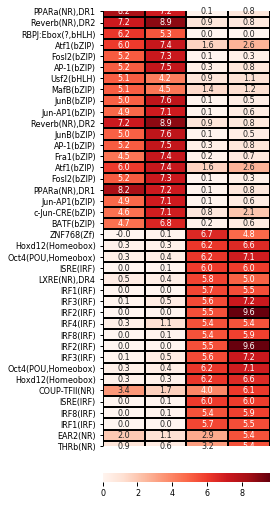

In [38]:
top_n = 10


# filter data
df = known_motif_pval_frame.loc[:, known_motif_pval_frame.columns.str.contains('hunterFCThenPadj')]
# df = df.loc[:, ~df.columns.str.contains('distal')]
df = df.loc[:, df.columns.str.contains('trans')]

# select top motifs
motifs = []
for col in df.columns:
    motifs.extend(df.sort_values(col, ascending=True).index.tolist()[:top_n])
    
fig, ax = plt.subplots(figsize=(3,10))

tmp_df = -df.loc[motifs]
tmp_df.index = tmp_df.index.str.split('/').str[0]

sns.heatmap(tmp_df,
            cmap='Reds',
            linewidth=1,
            linecolor='k',
            # vmax=25,
            annot=True,
            fmt='.1f',
            xticklabels=0,
            cbar_kws={'orientation':'horizontal',
                      'pad':0.05})
    

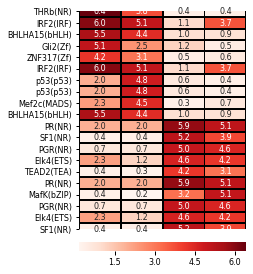

In [34]:
top_n = 5


# filter data
df = known_motif_pval_frame.loc[:, known_motif_pval_frame.columns.str.contains('hunterFCThenPadj')]
# df = df.loc[:, ~df.columns.str.contains('distal')]
df = df.loc[:, df.columns.str.contains('mixed')]

# select top motifs
motifs = []
for col in df.columns:
    motifs.extend(df.sort_values(col, ascending=True).index.tolist()[:top_n])
    
fig, ax = plt.subplots(figsize=(3,5))

tmp_df = -df.loc[motifs]
tmp_df.index = tmp_df.index.str.split('/').str[0]

sns.heatmap(tmp_df,
            cmap='Reds',
            linewidth=1,
            linecolor='k',
            # vmax=25,
            annot=True,
            fmt='.1f',
            xticklabels=0,
            cbar_kws={'orientation':'horizontal',
                      'pad':0.05})

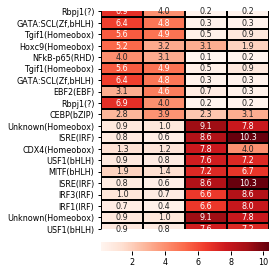

In [35]:
top_n = 5


# filter data
df = known_motif_pval_frame.loc[:, known_motif_pval_frame.columns.str.contains('hunterFCThenPadj')]
# df = df.loc[:, ~df.columns.str.contains('distal')]
df = df.loc[:, df.columns.str.contains('cis')]

# select top motifs
motifs = []
for col in df.columns:
    motifs.extend(df.sort_values(col, ascending=True).index.tolist()[:top_n])
    
fig, ax = plt.subplots(figsize=(3,5))

tmp_df = -df.loc[motifs]
tmp_df.index = tmp_df.index.str.split('/').str[0]

sns.heatmap(tmp_df,
            cmap='Reds',
            linewidth=1,
            linecolor='k',
            # vmax=25,
            annot=True,
            fmt='.1f',
            xticklabels=0,
            cbar_kws={'orientation':'horizontal',
                      'pad':0.05})